In [2]:
#  functions
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
import pypsa, pandas as pd, numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict
print("PyPSA:", pypsa.__version__)
def summarize(n):
    tables = ["buses","loads","generators","lines","links","transformers","storage_units"]
    counts = {t: getattr(n, t).shape[0] for t in tables}
    print(f"Network: {getattr(n, 'name', 'unknown')}")
    print("Snapshots:", len(getattr(n, "snapshots", [])))
    for t,c in counts.items():
        print(f"{t:14s}: {c}")
    if hasattr(n, "carriers") and not n.carriers.empty:
        print("\nCarriers defined:", ", ".join(n.carriers.index))
    else:
        print("\nCarriers defined: none")
# Default Parameters
DEFAULTS = {
#Begin carrier defaults
    "hours_start": "2025-01-01",
    "hours": 24,
    "represent_full_year": True,
    "demand_base_MW": 10,
    "demand_amp_MW": 5,
    "wind_capex": 900,
    "wind_mc": 15,
    "ocgt_capex": 500,
    "ocgt_mc": 70,
    "coal_capex": 650,
    "coal_mc": 40.0,
    "coal_p_min_pu": 0.50,
    "coal_ramp": 0.10,
    "battery_capex": 120,
    "battery_eff": 0.95,
    "battery_max_hours": 2,
    "hydro_capex": 1000,
    "hydro_eff": 0.90,
    "hydro_standing_loss": 0.001,
    "hydro_max_hours": 90,
    "hydro_inflow_base_MW": 5.0,
    "hydro_inflow_amp_MW": 3.0,
    "seed": 42,
    "voll": 5000.0,
    # emissions intensities
    "co2_intensity": {"gas": 0.40, "coal": 0.90},
    # policy knobs (currently price of carbon)
    "carbon_price_eur_per_t": 0.0,
    # define potential caps
    "wind_p_nom_max": 12,
    "ocgt_p_nom_max": None,
    "coal_p_nom_max": None,
    "hydro_p_nom_max": None,
    "battery_p_nom_max": None,
    # availability scaling
    "wind_availability_scale": 1.0,
    "demand_scale": 1.0,
    "hydro_inflow_scale": 1.0,
}

PyPSA: 0.35.2


In [3]:
def build_network(params):
    P={**DEFAULTS,**params} #replace defaults by scenario variables
    n = pypsa.Network() #define network
    n.name = P.get("name","toy-24h") #allow for scenario to vary name

    # time snapshots, add number of shots, define yearly scale
    hours = pd.date_range(P["hours_start"], periods=P["hours"], freq="h")
    n.set_snapshots(hours) #take hourly snapshots of system
    H = len(hours)
    #define yearly scale, assume representative day
    if P["represent_full_year"]:
        weight = 8760 / len(hours)
        n.snapshot_weightings = pd.Series(weight, index=hours)

    #define carriers
    carrier_list=["electricity","wind","gas","battery","coal","hydro","shed"]
    for c in carrier_list:
        n.add("Carrier",c)

    #add bus
    n.add("Bus","bus0", carrier="electricity")

    #add load profile, match snapshots, assume sin pattern, vary 5 MW to 15 MW throughout day
    hangles = np.linspace(0, 2*np.pi, H, endpoint=False)
    p = (P["demand_base_MW"] + P["demand_amp_MW"]*np.sin(hangles)) * P["demand_scale"]
    n.add("Load","demand", bus="bus0", p_set=p)

    # add wind profile
    rng = np.random.default_rng(P["seed"]) #start rng generator, add preselected seed
    wind_avail = rng.random(H) * P["wind_availability_scale"] #scale for availability
    wind_avail = np.clip(wind_avail, 0.0, 1.0) #set cutoff

    # inflow profile
    inflow = (P["hydro_inflow_base_MW"] + P["hydro_inflow_amp_MW"]*np.sin(hangles)) * P["hydro_inflow_scale"]

    # add carbon price uplift
    cp = P["carbon_price_eur_per_t"]
    gas_uplift = P["co2_intensity"]["gas"]*cp
    coal_uplift = P["co2_intensity"]["coal"]*cp

#add generators and storage

    # add wind generator small random marginal cost, random load avaialabiltiy between 0 and 1
    n.add("Generator","wind", bus="bus0", carrier="wind",
        p_max_pu=wind_avail, #import availability
        p_nom_extendable=True, #allow for optimized capacity
        p_nom_max=P["wind_p_nom_max"], #add upper limit capacity
        capital_cost=P["wind_capex"],
        marginal_cost=P["wind_mc"])

    # add gas generator, built for backup, high marginal cost, include uplift
    n.add("Generator","ocgt", bus="bus0", carrier="gas",
       p_nom_extendable=True,
       p_nom_max=P["ocgt_p_nom_max"],
       capital_cost=P["ocgt_capex"],
       marginal_cost=P["ocgt_mc"] + gas_uplift)

    # add coal power plant (high capital cost, lower marginal than gas, stable load, include ramp limit)
    n.add("Generator","coal_pp", bus="bus0", carrier="coal",
       p_nom_extendable=True,
       p_nom_max=P["coal_p_nom_max"],
       capital_cost=P["coal_capex"],
       marginal_cost=P["coal_mc"] + coal_uplift,
       p_min_pu=P["coal_p_min_pu"], #set minimum stable load
       ramp_limit_up=P["coal_ramp"], #set variation limit
       ramp_limit_down=P["coal_ramp"])

    #  add battery storage
    n.add("StorageUnit","battery", bus="bus0", carrier="battery",
        p_nom_extendable=True,
        p_nom_max=P["battery_p_nom_max"],
        max_hours=P["battery_max_hours"],
        efficiency_store=P["battery_eff"],
        efficiency_dispatch=P["battery_eff"],
        capital_cost=P["battery_capex"])

    # add hydro reservoir storage, high capital cost, no fuel cost
    n.add("StorageUnit","hydro_dam", bus="bus0", carrier="hydro",
        p_nom_extendable=True,
        p_nom_max=P["hydro_p_nom_max"],
        max_hours=P["hydro_max_hours"],
        efficiency_store=1.0,
        efficiency_dispatch=P["hydro_eff"], #efficiency in energy conversion
        standing_loss=P["hydro_standing_loss"], #standing reservior losses
        capital_cost=P["hydro_capex"])
    n.storage_units.loc["hydro_dam","cyclic_state_of_charge"] = True #make the dam cyclic
    n.storage_units_t.inflow.loc[:, "hydro_dam"] = pd.Series(inflow, index=hours) #add the inflow to the dam inflow table

    #Add high-cost shed generator
    n.add("Generator","shed", bus="bus0", carrier="shed", # placeholder high cost, releiabilty tester
            p_nom_extendable=True, marginal_cost=P["voll"], capital_cost=0.0)

    # toy emission dictionary
    n._co2_intensity = P["co2_intensity"]

    return n

#define kpi function
def kpis(n):
    #add failsafe for network co2 intensity
    if not hasattr(n, "_co2_intensity"):
        print("⚠ Warning: '_co2_intensity' missing, using default values (gas=0.4, coal=0.9)") #issue warning
        CO2_INT = {"gas":0.4, "coal":0.9} #manually repeat defaults
    else:
        CO2_INT = n._co2_intensity

    em = 0.0 #define emissions accumulator
    for g, row in n.generators.iterrows(): #loop over the generators
        em += CO2_INT.get(row.carrier, 0.0) * n.generators_t.p[g].sum() #add emissions based on number of generators (intensity*energy)

    # check for unment demand
    shedt = n.generators_t.p["shed"].sum() if "shed" in n.generators_t.p.columns else 0.0 #sum total amount of shed power if used

    #capacity mix (MW)
    mix = n.generators.copy() #copy geneator list
    cap_col = "p_nom_opt" if "p_nom_opt" in mix.columns else "p_nom" #group the p_nom
    mix["cap_MW"] = mix[cap_col] #add a new column of p_nom
    caps = mix.groupby("carrier")["cap_MW"].sum().to_dict() #collapse the common columns and sum by carrier

    # list generators generators with non-negligible capacity
    gens_used = n.generators[cap_col][n.generators[cap_col] > 1e-6].to_dict()

    #average prices for both snapshots and buses
    mp = float(n.buses_t.marginal_price.mean().mean())

  #Curtailment by carrier (avaialable energy not produced)
    curtailment_by_carrier = {} #start with empty dict
    if hasattr(n.generators_t, "p_max_pu"): #check for generators of variable output "p_max_pu"
        for g in n.generators.index: #search for generator in dict
            if g in n.generators_t.p.columns and g in n.generators_t.p_max_pu.columns: #check that generators has both dispatch time series and avaialbility series
                p_nom_g = n.generators.at[g, cap_col] #get the generator's capcaity
                available = n.generators_t.p_max_pu[g] * p_nom_g #multiply availabilty by capacity
                curtailed = (available - n.generators_t.p[g]).clip(lower=0).sum() #calculate curtailment and sum
                if curtailed > 0: #check if curtailment occured
                    carr = n.generators.at[g, "carrier"]# isolate curtailed generator
                    curtailment_by_carrier[carr] = curtailment_by_carrier.get(carr, 0.0) + float(curtailed) #poupulate the dict with curtailed carrties and values

    # neat output of resulting kpis
    out = dict(generators_used=gens_used,
               system_cost=float(n.objective),
               emissions_t=float(em),
               unserved_MWh=float(shedt),
               mean_price_eur_per_MWh=mp,
                             **caps)
    for carr, val in curtailment_by_carrier.items(): #include the curtailemnt dictionary
        out[f"curtail_{carr}_MWh"] = val
    return out

def run_scenario(name, overrides):
    params = {"name": name, **overrides}
    n = build_network(params)
    n.optimize(solver_name="highs")
    return n, kpis(n)

# add sanity checks
def sanity_checks(n):
    # Power balance residual
    resid = (n.generators_t.p.sum(axis=1)
             + n.storage_units_t.p_dispatch.sum(axis=1)
             - n.storage_units_t.p_store.sum(axis=1)
             - n.loads_t.p.sum(axis=1))
     max_resid = float(resid.abs().max())

    # Check for unmet demand via shed dispatch
    shed = n.generators_t.p["shed"].sum() if "shed" in n.generators_t.p.columns else 0.0
    shed = float(shed)

    # Peak-hour binding unit
    mp = n.buses_t.marginal_price
    t_peak = mp.mean(axis=1).idxmax()
    peak_price = float(mp.loc[t_peak].mean())
    dispatch_at_peak = n.generators_t.p.loc[t_peak].sort_values(ascending=False).head()

    #neat ouput dictionary
     out = {
        "max_power_balance_residual": max_resid,
        "total_shed_MWh": shed,
        "peak_snapshot": t_peak,
        "peak_price_EUR_per_MWh": peak_price,
        "dispatch_at_peak": dispatch_at_peak.to_dict(),
    }

    print("Sanity Checks:")
    print(f"  Max |power balance residual|: {max_resid}")
    print(f"  Total shed (MWh): {shed}")
    print(f"  Peak price snapshot: {t_peak}  (€/MWh: {peak_price})")
    print("  Dispatch at peak (top few):")
    print(dispatch_at_peak)

    return out

# Plotting functions

#dispatch plot function
def plot_dispatch_stack(n, show_load=True, load_scale="auto", outfile="dispatch_stack.png",
                        figsize=(11,5)):

    #create a supply dispatch dataframe

    by_supply = {} #create empty supply dictionary
    by_sink = {} # create empty sink dictionary
    #Supplying Generators
    gen = n.generators.copy() # 1 row per generator
    (P := n.generators_t.p.copy()).columns.name = None    # dispatch time-series
    for g, row in gen.iterrows(): #loop over indexes and rows in generator dataframe
        if g in P.columns: #check that the generator has dispathced
            by_supply.setdefault(row.carrier, 0) #set generator to dictionary with default value 0
            by_supply[row.carrier] = by_supply[row.carrier] + P[g] #add all generators to dictionary by carrier


    #Storage series
    if hasattr(n, "storage_units_t") and not n.storage_units.empty: #check that storage units have been used
        sstore = n.storage_units.copy() #1 row per storage units

        #Supplying storage
        if hasattr(n.storage_units_t, "p_dispatch"): #check that storage units exist and have been dispached
            (SP := n.storage_units_t.p_dispatch.copy()).columns.name = None    # dispatch time-series
            if not SP.empty:
                for su, row in sstore.iterrows(): # loop over indexes and rows in the storage unit dataframe
                    if su in SP.columns: #for each storage unit lavel
                        by_supply.setdefault(row.carrier, 0) #set default to 0
                        by_supply[row.carrier] = by_supply[row.carrier] + SP[su] #dispatch series to dictionary

        #Sinking Storage
        if hasattr(n.storage_units_t, "p_store"):
            (SiP := n.storage_units_t.p_store.copy()).columns.name = None #sink time series
            if not SiP.empty:
                for su, row in sstore.iterrows():
                    if su in SiP.columns:
                        by_sink.setdefault(row.carrier + "_charge", 0)  # separate label to avoid mixing
                        by_sink[row.carrier + "_charge"] = by_sink[row.carrier + "_charge"] + SiP[su]

    #Create supply dataframe
    df = pd.DataFrame(by_supply).fillna(0) #convert to panda data frame, replace missing values with zeroes

    #Create sink dataframe if sinks exist
    if by_sink:
        sinks = pd.DataFrame({k: -v for k, v in by_sink.items()}).fillna(0) #assign negative value to the sinks
        df = df.join(sinks, how="left").fillna(0) #join the supply and sinks dataframe

    fig, ax = plt.subplots(figsize=(11,5))

    # Split positives and negatives
    pos = df.clip(lower=0)
    neg = df.clip(upper=0)

    pos.plot.area(ax=ax, linewidth=0)
    neg.plot.area(ax=ax, linewidth=0, legend=False)


    ax.set_title("System Dispatch Stack")
    ax.set_xlabel("Time")
    ax.set_ylabel("Power [MW]")

    # Deduplicate legend labels
    handles, labels = ax.get_legend_handles_labels()
    unique = OrderedDict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h

    # Move legend outside so it doesn't cover the plot
    ax.legend(unique.values(), unique.keys(),
              loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., frameon=False)

    fig.tight_layout()
    fig.savefig("dispatch_stack.png", dpi=300, bbox_inches="tight")
    plt.show()

    return df


# # first 9 hours for all storage units
# print("\nStorage discharge p_dispatch (MW), first 9h:")
# print(n.storage_units_t.p_dispatch.head(9))
# print("\nStorage charge p_store (MW), first 9h:")
# print(n.storage_units_t.p_store.head(9))
# print("\nStorage state of charge (MWh), first 9h:")
# print(n.storage_units_t.state_of_charge.head(9))

# #print size and dispatch
# print("Optimal capacities (MW):\n", n.generators.p_nom_opt)
# print("\nDispatch (first 9 hours, MW):\n", n.generators_t.p.head(9))

# #print hydro inflow
# if "hydro_dam" in n.storage_units.index:
#     print("\n[hydro_dam] inflow (MW), first 9h:")
#     print(n.storage_units_t.inflow["hydro_dam"].head(9))


In [3]:
# Run base scenario
n_base, res_base = run_scenario("baseline", {})
sanity_checks(n_base)
print(res_base)

NameError: name 'run_scenario' is not defined

In [4]:
# Toy Block

# network
n, _ = run_scenario("scratch", {})

INFO:pypsa.network.index:Applying weightings to all columns of `snapshot_weightings`
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 270 primals, 605 duals
Objective: 9.51e+05
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-c15ul0j1 has 605 rows; 270 cols; 1296 nonzeros
Coefficient ranges:
  Matrix [6e-02, 4e+02]
  Cost   [1e+02, 2e+06]
  Bound  [2e+00, 8e+00]
  RHS    [5e+00, 3e+03]
Presolving model
358 rows, 269 cols, 1025 nonzeros  0s
Dependent equations search running on 71 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
357 rows, 268 cols, 1023 nonzeros  0s
Presolve : Reductions: rows 357(-248); columns 268(-2); elements 1023(-273)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.7155000000e+08 Ph1: 74(125225); Du: 24(171550) 0s
        289     9.5100244033e+05 Pr: 0(0); Du: 0(1.42109e-14) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-c15ul0j1
Model status        : Optimal
Simp

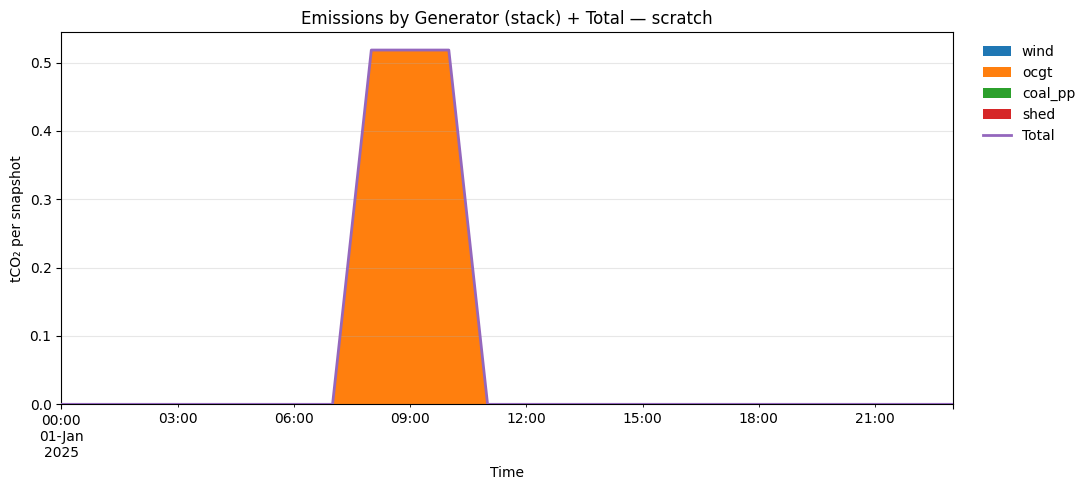

In [61]:
# Check CO2 metrics have been defined
if hasattr(n, "_co2_intensity"):
   CO2_INT = dict(n._co2_intensity)
else:
    print("⚠ Warning: '_co2_intensity' missing, using default values (gas=0.4, coal=0.9)")
    CO2_INT = {"gas": 0.40, "coal": 0.90}

# Create emission time series
gen = n.generators.copy()  # 1 row per generator
(P := n.generators_t.p.copy()).columns.name = None  # dispatch time-series
intens_by_gen = gen.carrier.map(lambda c: CO2_INT.get(c, 0.0))  #create a pandas table with emission intensity by generator
emissions_by_gen = (P * intens_by_gen) # total emissions per hour (generator independent)
emissions_t=emissions_by_gen.sum(axis=1)

#group emissions by bus
bus_of_gen=gen.bus #list generator by bus
emissions_by_bus = emissions_by_gen.groupby(bus_of_gen, axis=1).sum(min_count=1) #sum all emission eat each bus for each timestamp

# Plot
fig, ax = plt.subplots(figsize=(11,5))

#stacked area is generator
emissions_by_gen.plot.area(ax=ax, linewidth=0)

# total emission line
emissions_t.plot(ax=ax, lw=2, label="Total", zorder=5)

ax.set_title(f"Emissions by Generator (stack) + Total — {getattr(n, 'name','scenario')}")
ax.set_xlabel("Time")
ax.set_ylabel("tCO\u2082 per snapshot")
ax.grid(True, alpha=0.3)

# legend Layout
handles, labels = ax.get_legend_handles_labels()
# move "Total" to the end if present
if "Total" in labels:
    total_idx = labels.index("Total")
    handles = handles[:total_idx] + handles[total_idx+1:] + [handles[total_idx]]
    labels  = labels[:total_idx]  + labels[total_idx+1:]  + ["Total"]
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.02,1), frameon=False)

fig.tight_layout()
fig.savefig("emissions_by_generator_stack.png", dpi=300, bbox_inches="tight")
plt.show()

In [37]:
bus_of_gen=gen.bus
emissions_by_bus = emissions_by_gen.groupby(bus_of_gen, axis=1).sum(min_count=1)

In [58]:
print(bus_of_gen)

Generator
wind       bus0
ocgt       bus0
coal_pp    bus0
shed       bus0
Name: bus, dtype: object


In [59]:
print(emissions_by_gen.groupby(bus_of_gen, axis=1).groups)

{'bus0': ['wind', 'ocgt', 'coal_pp', 'shed']}


In [1]:
pwd

'/home/aris/projects/pypsa-nl'